# Eg1: (Code generated by New Bing) 

prompt1: 帮我构造一个神经网络拟合目标函数的例子，目标函数是$sin(x)+a*sin(4x)$。我们假设a为[0.5,2]中的linspace采样，对于不同的a，我们均训练8000步，并记录每一步神经网络的输出，并保存到以a为key的字典中，每个key对应的值是一个列表，这个列表记录了每10步网络的输出值。神经网络的结构为五层神经网络，宽度为256,以Tanh作为激活函数. 我们使用full batch的Adam进行训练，学习率为1e-4. 对于input data，我们希望它是在[-pi, pi]上的linspace采样。你需要注意，模型的input与output应该具有相同的size。

In [12]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x
    


def train(a):
    net = Net()
    optimizer = Adam(net.parameters(), lr=5e-5)
    criterion = nn.MSELoss()
    x = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
    y = np.sin(x) + a * np.sin(4 * x)
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    res_dict = {}
    res_list = []
    for i in range(4000):
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        # if i % 10 == 0:
        res_list.append(y_pred.detach().numpy())
        if i % 1000 == 0:
            print(f'a={a:.2f}, Step {i}: Loss = {loss.item():.4f}')
    res_dict[a] = res_list
    return res_dict


a_list = np.linspace(1, 3, 5)
res_dict_a = {}
for a in a_list:
    res_dict_a.update(train(a))



a=1.00, Step 0: Loss = 1.0434
a=1.00, Step 1000: Loss = 0.0540
a=1.00, Step 2000: Loss = 0.0005
a=1.00, Step 3000: Loss = 0.0001
a=1.50, Step 0: Loss = 1.5411
a=1.50, Step 1000: Loss = 0.0650
a=1.50, Step 2000: Loss = 0.0009
a=1.50, Step 3000: Loss = 0.0001
a=2.00, Step 0: Loss = 2.4413
a=2.00, Step 1000: Loss = 0.0264
a=2.00, Step 2000: Loss = 0.0065
a=2.00, Step 3000: Loss = 0.0003
a=2.50, Step 0: Loss = 3.6229
a=2.50, Step 1000: Loss = 0.0591
a=2.50, Step 2000: Loss = 0.0085
a=2.50, Step 3000: Loss = 0.0005
a=3.00, Step 0: Loss = 4.9921
a=3.00, Step 1000: Loss = 0.0746
a=3.00, Step 2000: Loss = 0.0111
a=3.00, Step 3000: Loss = 0.0005


Prompt2: 在上面这个代码中，我们获得了res_dict，包含每一个$a$对应的目标函数在训练过程中的输出。我们的目标函数是sin（x）+a*sin(4x), 现在我希望对每个a，计算模型每步训练时，在频率为1和频率为5处模型的输出与目标函数在傅里叶空间的相对误差。也就是对训练的每一步，对模型输出及目标函数进行傅里叶变换，取他们频率为1的模长，求相对误差，再取他们频率为5的模长，求相对误差。

In [13]:
from numpy.fft import fft

error_1_list_all=[]
error_5_list_all=[]

def calc_relative_error(res_dict, a):
    x = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
    y = np.sin(x) + a * np.sin(4 * x)
    y_fft = fft(y.squeeze())
    error_1_list = []
    error_5_list = []
    for y_pred in res_dict[a]:
        y_pred_fft = fft(y_pred.squeeze())
        error_1 = abs(abs(y_fft[1]) - abs(y_pred_fft[1])) / abs(y_fft[1])
        error_5 = abs(abs(y_fft[4]) - abs(y_pred_fft[4])) / abs(y_fft[4])
        error_1_list.append(error_1)
        error_5_list.append(error_5)
    return error_1_list, error_5_list


for a in a_list:
    error_1_list, error_5_list = calc_relative_error(res_dict_a, a)
    error_1_list_all.append(error_1_list)
    error_5_list_all.append(error_5_list)   



Prompt3: 假设对于a_list中的每个a，我们都得到了error_1_list和error_5_list，并把它们保存在列表error_1_list_all及error_5_list_all中，现在我们需要对每个a，找出其对应的error_1_list和error_5_list中error首次小于0.1的error的index，记为error_1_index及error_5_index，对于不同的a，我们都可以计算error_1_index/error_5_index的值。最后我们绘制一张横坐标为a，纵坐标为error_1_index/error_5_index的图像。

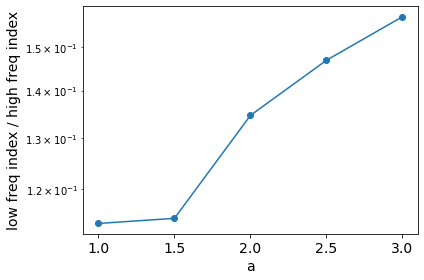

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import os



def find_consecutive_index(arr):
    for i in range(len(arr) - 10):
        if all(arr[i+j] == arr[i] + j for j in range(10)):
            return arr[i]

def calc_error_index(error_1_list_all, error_5_list_all):
    error_1_index_list = []
    error_5_index_list = []
    for error_1_list, error_5_list in zip(error_1_list_all, error_5_list_all):

        error_1_index = np.where(np.array(error_1_list) < 0.1)[0]
        error_5_index = np.where(np.array(error_5_list) < 0.1)[0]
        error_1_index = find_consecutive_index(error_1_index)
        error_5_index = find_consecutive_index(error_5_index)

        error_1_index_list.append(error_1_index)
        error_5_index_list.append(error_5_index)


    return error_1_index_list, error_5_index_list



error_1_list_all = []
error_5_list_all = []
for a in a_list:
    error_1_list, error_5_list = calc_relative_error(res_dict_a, a)
    error_1_list_all.append(error_1_list)
    error_5_list_all.append(error_5_list)

error_1_index_list, error_5_index_list = calc_error_index(error_1_list_all, error_5_list_all)

ratio = np.array(error_1_index_list) / np.array(error_5_index_list)
plt.plot(a_list, ratio, 'o-')
plt.xlabel('a', fontsize=14)
plt.yscale('log')
plt.ylabel('low freq index / high freq index', fontsize=14)
# plt.yticks([0.02, 0.03])
plt.xticks([1,1.5,2,2.5, 3])
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(args.path, 'amplitudes.png'))
plt.show()
plt.close()


# Eg2: Different high frequencies
Network model and training process definition.

In [15]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x
    


def train(k):
    net = Net()
    optimizer = Adam(net.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    x = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
    y = np.sin(x) + 0.2*np.sin(k * x)
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    res_dict = {}
    res_list = []
    for i in range(10000):
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        # if i % 10 == 0:
        res_list.append(y_pred.detach().numpy())
        if i % 1000 == 0:
            print(f'k={k:.2f}, Step {i}: Loss = {loss.item():.4f}')
    res_dict[k] = res_list
    return res_dict


# k_list = np.linspace(1, 3, 20)
k_list=[1,2,3, 4, 5]
res_dict_k = {}
for k in k_list:
    res_dict_k.update(train(k))

k=1.00, Step 0: Loss = 0.7088
k=1.00, Step 1000: Loss = 0.0000
k=1.00, Step 2000: Loss = 0.0000
k=1.00, Step 3000: Loss = 0.0001
k=1.00, Step 4000: Loss = 0.0000
k=1.00, Step 5000: Loss = 0.0000
k=1.00, Step 6000: Loss = 0.0000
k=1.00, Step 7000: Loss = 0.0000
k=1.00, Step 8000: Loss = 0.0000
k=1.00, Step 9000: Loss = 0.0000
k=2.00, Step 0: Loss = 0.4995
k=2.00, Step 1000: Loss = 0.0000
k=2.00, Step 2000: Loss = 0.0000
k=2.00, Step 3000: Loss = 0.0000
k=2.00, Step 4000: Loss = 0.0000
k=2.00, Step 5000: Loss = 0.0000
k=2.00, Step 6000: Loss = 0.0000
k=2.00, Step 7000: Loss = 0.0000
k=2.00, Step 8000: Loss = 0.0000
k=2.00, Step 9000: Loss = 0.0000
k=3.00, Step 0: Loss = 0.4587
k=3.00, Step 1000: Loss = 0.0030
k=3.00, Step 2000: Loss = 0.0001
k=3.00, Step 3000: Loss = 0.0001
k=3.00, Step 4000: Loss = 0.0000
k=3.00, Step 5000: Loss = 0.0000
k=3.00, Step 6000: Loss = 0.0000
k=3.00, Step 7000: Loss = 0.0000
k=3.00, Step 8000: Loss = 0.0000
k=3.00, Step 9000: Loss = 0.0000
k=4.00, Step 0: Los

The relative error between the model output and the target function at different frequencies.

In [18]:
from numpy.fft import fft

error_1_list_all=[]
error_5_list_all=[]

def calc_relative_error(res_dict, k):
    x = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
    y = np.sin(x) + 0.2*np.sin(k * x)
    y_fft = fft(y.squeeze())
    error_1_list = []
    error_5_list = []
    for y_pred in res_dict[k]:
        y_pred_fft = fft(y_pred.squeeze())
        error_1 = abs(abs(y_fft[1]) - abs(y_pred_fft[1])) / abs(y_fft[1])
        error_5 = abs(abs(y_fft[k]) - abs(y_pred_fft[k])) / abs(y_fft[k])
        error_1_list.append(error_1)
        error_5_list.append(error_5)
    return error_1_list, error_5_list


for k in k_list:
    error_1_list, error_5_list = calc_relative_error(res_dict_k, k)
    error_1_list_all.append(error_1_list)
    error_5_list_all.append(error_5_list)   
    # print(f'For a={a}, the relative errors at frequency 1 are {error_1_list}, the relative errors at frequency 5 are {error_5_list}')



Plot

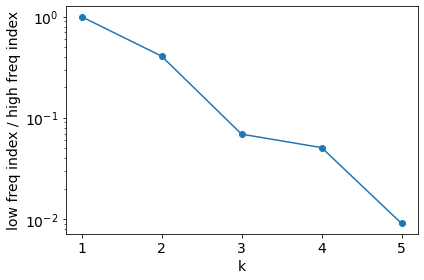

In [19]:
import matplotlib.pyplot as plt

def find_consecutive_index(arr):
    for i in range(len(arr) - 10):
        if all(arr[i+j] == arr[i] + j for j in range(10)):
            return arr[i]
    # return -1


def calc_error_index(error_1_list_all, error_5_list_all):
    error_1_index_list = []
    error_5_index_list = []
    for error_1_list, error_5_list in zip(error_1_list_all, error_5_list_all):

        error_1_index = np.where(np.array(error_1_list) < 0.05)[0]
        error_5_index = np.where(np.array(error_5_list) < 0.05)[0]
        error_1_index = find_consecutive_index(error_1_index)
        error_5_index = find_consecutive_index(error_5_index)

        error_1_index_list.append(error_1_index)
        error_5_index_list.append(error_5_index)


    return error_1_index_list, error_5_index_list



error_1_list_all = []
error_5_list_all = []
for k in k_list:
    error_1_list, error_5_list = calc_relative_error(res_dict_k, k)
    error_1_list_all.append(error_1_list)
    error_5_list_all.append(error_5_list)

error_1_index_list, error_5_index_list = calc_error_index(error_1_list_all, error_5_list_all)

ratio = np.array(error_1_index_list) / np.array(error_5_index_list)
plt.plot(k_list, ratio, 'o-')
plt.xticks([1,2,3,4,5])
plt.xlabel('k', fontsize=14)
plt.yscale('log')
plt.ylabel('low freq index / high freq index', fontsize=14)
# plt.yticks([0.02, 0.03])
plt.xticks([1,2,3, 4, 5])
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.ylabel('low freq index / high freq index')
# plt.savefig(os.path.join(args.path, 'frequencies.png'))
plt.show()

plt.close()
